## Applied Machine Learning Homework 3 Task 3

Peter Grantcharov (pdg2116), Po-Chieh Liu (pl2441)

**The overall goal is to predict whether a payment by a company to a medical doctor or facility was made as part of a research project or not.**

In [1]:
# import base packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Task 3 Feature Engineering
1. Create derived features and perform more in-depth preprocessing and data cleaning. 
2. Does this improve your model? In particular, think about how to encode categorical variables

## Before Commencing
From task 1, we selected potential features for building model. In task 2, we built a baseline model using a logistic regression, with a subset of potential features to predict the payment type. For this task, some features that were skipped in task 2 due to large amount unique values or large amount missing values will now have target-based encoding applied to them, to see if we can improve on our baseline model.

### Import data

Based on task 1 and 2 results.

In [2]:
# Selected features
col  = ['Recipient_State',
        'Recipient_Country',
        'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
        'Total_Amount_of_Payment_USDollars', 
        'Date_of_Payment', 
        'Form_of_Payment_or_Transfer_of_Value',
        'Dispute_Status_for_Publication', 
        'Related_Product_Indicator',
        'Covered_or_Noncovered_Indicator_1',
        'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
        'Covered_or_Noncovered_Indicator_2',
        'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
        'Covered_or_Noncovered_Indicator_3',
        'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3',
       ]

# import file 1 and 2
file1 = pd.read_csv('OP_DTL_GNRL_PGYR2017_P01182019.csv', usecols = col)
file2 = pd.read_csv('OP_DTL_RSRCH_PGYR2017_P01182019.csv', usecols = col)

# Labeling
file1['y'] = int(0)
file2['y'] = int(1)

# combine (vertical stack)
df = pd.concat([file1, file2], sort = False)

# convert to datatime type and reduce to month only
df['Date_of_Payment'] = pd.to_datetime(df.Date_of_Payment, format = "%m/%d/%Y")
df['Date_of_Payment'] = pd.DatetimeIndex(df['Date_of_Payment']).month
df['Date_of_Payment'] = df['Date_of_Payment'].astype(int)

# free memory
del file1, file2, col


### Missing data
#### Recipient_State and Recipient_Country

In [3]:
# Labelling all missing states as "Unknown"
df.Recipient_State[df.Recipient_State.isnull()] = 'Unknown'

In [4]:
# Grouping all non-us countries and United States Minor Outlying Islands together
df.Recipient_Country[~(
    (df.Recipient_Country == 'United States') |  (df.Recipient_Country.isnull()))] = 'Other'

# assign missing country as unknown country
df.Recipient_Country[df.Recipient_Country.isnull()] = 'Unknown'

#### Covered_or_Noncovered_Indicator

In [5]:
# Assign not applicable for missing value
df.Covered_or_Noncovered_Indicator_1[df.Covered_or_Noncovered_Indicator_1.isnull()] = 'M1'
df.Covered_or_Noncovered_Indicator_2[df.Covered_or_Noncovered_Indicator_2.isnull()] = 'M2'
df.Covered_or_Noncovered_Indicator_3[df.Covered_or_Noncovered_Indicator_3.isnull()] = 'M3'

#### Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1

In [6]:
# if the Related_Product_Indicator indicator is Yes, then at least 1 item should be related
# so assume the missing of 1st indicator is missing
for i in range(1, 4):
    name = 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_' + str(i)
    df[name][( (df.Related_Product_Indicator == 'Yes') & (df[name].isnull()))] = 'Unknown' + str(i)

    # The missing indicator 1 with No of related indicator should be NA
    df[name][((df.Related_Product_Indicator == 'No'))] = 'NA' + str(i)


In [7]:
# check missing
for el in df.columns:
    tmp = df[el].isna().sum()
    if tmp == 0:
        print('0 missing data of feature ' + str(el))
    else:
        print(str(el) + ' has\n number of missing rows : ' + str(tmp) + '\n ratio : ' + str(tmp/df.shape[0]))

0 missing data of feature Recipient_State
0 missing data of feature Recipient_Country
0 missing data of feature Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID
0 missing data of feature Total_Amount_of_Payment_USDollars
0 missing data of feature Date_of_Payment
0 missing data of feature Form_of_Payment_or_Transfer_of_Value
0 missing data of feature Dispute_Status_for_Publication
0 missing data of feature Related_Product_Indicator
0 missing data of feature Covered_or_Noncovered_Indicator_1
0 missing data of feature Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1
0 missing data of feature Covered_or_Noncovered_Indicator_2
0 missing data of feature Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2
0 missing data of feature Covered_or_Noncovered_Indicator_3
0 missing data of feature Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3
0 missing data of feature y


### Target-based Encoding

In [8]:
df_t = df.copy()

#### Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID

In [9]:
Manufacturer_mean = df_t.groupby('Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID')['y'].mean()
df_t['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'] = df_t[
    'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'].map(Manufacturer_mean)

#### Covered_or_Noncovered_Indicator_2-3

In [10]:
Cover2_mean = df_t.groupby(
    'Covered_or_Noncovered_Indicator_2')['y'].mean()
df_t['Covered_or_Noncovered_Indicator_2'] = df_t[
    'Covered_or_Noncovered_Indicator_2'].map(Cover2_mean)

Cover3_mean = df_t.groupby(
    'Covered_or_Noncovered_Indicator_3')['y'].mean()
df_t['Covered_or_Noncovered_Indicator_3'] = df_t[
    'Covered_or_Noncovered_Indicator_3'].map(Cover3_mean)


#### Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2-3

In [11]:
ind2_mean = df_t.groupby(
    'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2')['y'].mean()
df_t['Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2'] = df_t[
    'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2'].map(ind2_mean)

ind3_mean = df_t.groupby(
    'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3')['y'].mean()
df_t['Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3'] = df_t[
    'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3'].map(ind3_mean)


#### Check status

In [12]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11266363 entries, 0 to 602529
Data columns (total 15 columns):
Recipient_State                                                object
Recipient_Country                                              object
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID    float64
Total_Amount_of_Payment_USDollars                              float64
Date_of_Payment                                                int64
Form_of_Payment_or_Transfer_of_Value                           object
Dispute_Status_for_Publication                                 object
Related_Product_Indicator                                      object
Covered_or_Noncovered_Indicator_1                              object
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1      object
Covered_or_Noncovered_Indicator_2                              float64
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2      float64
Covered_or_Noncovered_Indicator_3           

### Build model

In [13]:
# import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

#### Subsample and Perform Train-Test Split

In [14]:
# list 
col = [el for el in df.columns if el != 'y']

# sample data
rand = np.random.choice(df.index.values, int(len(df) * 0.001))
s_df = df_t.ix[rand]

# subset features
X = s_df.loc[:, col]
y = s_df.loc[:,'y']

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 1, 
                                                    stratify = y, 
                                                    train_size = 0.75)

#### Define Categorical and Continuous Variable Lists

In [17]:
# categorical list 
ct_ls = [x for x in col if (
    (x != 'Total_Amount_of_Payment_USDollars') &
    (x != 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID') &
    (x != 'Covered_or_Noncovered_Indicator_2') &
    (x != 'Covered_or_Noncovered_Indicator_3') &
    (x != 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2') &
    (x != 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3'))]

# continuous list
cts_ls = [x for x in col if x not in ct_ls]

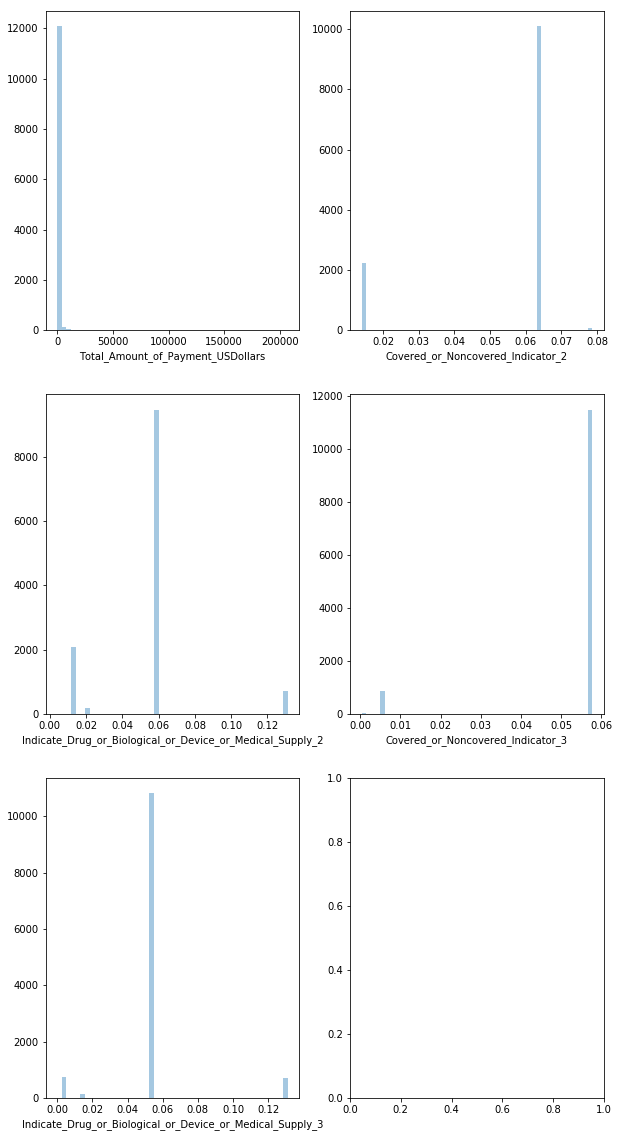

In [18]:
f, ax = plt.subplots(3, 2, figsize= (10,20))
ax_ = ax.flatten()
for idx, el in enumerate(cts_ls[1:]):
    _ = sns.distplot(X[el], kde = False, ax = ax_[idx])

#### Build Pipeline

In [19]:
# preprocess pipe
# PowerTransformer() also standardize the data 
preprocess = make_column_transformer(
    (PowerTransformer(), cts_ls),
    (OneHotEncoder(sparse = False, handle_unknown='ignore'), ct_ls),
    remainder='passthrough')

# logistic pipe
lr = LogisticRegression(dual = False, solver = "sag", penalty = 'l2')
logistic_pipe = make_pipeline(preprocess, lr) 

#### Define metrics

In [20]:
# metric we want to use
scoring = {'balanced_accuracy' : 'balanced_accuracy',
           'precision' : 'precision',
           'average_precision' : 'average_precision', 
           'recall' : 'recall',
           'f1' : 'f1'}

#### Evaluate

In [21]:
# build using small subset
scores = cross_validate(logistic_pipe, X_train, y_train, scoring = scoring)

In [22]:
for el in scores.keys():
    if el in ['test_balanced_accuracy', 'test_precision', 'test_average_precision', 'test_recall', 'test_f1']:
        print(el + ' : ' + str(np.mean(scores[el])))

test_balanced_accuracy : 0.8595186648498924
test_precision : 0.815214934822778
test_average_precision : 0.8527731899642389
test_recall : 0.7361969534264009
test_f1 : 0.7735703514657261


### Smooth Target-based Encoding

In [23]:
# Source: https://maxhalford.github.io/blog/target-encoding-done-the-right-way/

def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

In [24]:
df_t_s = df.copy()

In [25]:
temp_ = ['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
         'Covered_or_Noncovered_Indicator_2',
         'Covered_or_Noncovered_Indicator_3',
         'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
         'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3']

In [26]:
# smooth target encoding
for el in temp_:
    df_t_s[el] = calc_smooth_mean(df_t_s, by = el, on = 'y', m = 300)

In [27]:
# sample data
rand = np.random.choice(df.index.values, int(len(df) * 0.001))
s_df = df_t_s.ix[rand]

# subset features
X = s_df.loc[:, col]
y = s_df.loc[:,'y']

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 1, 
                                                    stratify = y, 
                                                    train_size = 0.75)

In [29]:
# build using small subset
scores = cross_validate(logistic_pipe, X_train, y_train, scoring = scoring)

In [30]:
for el in scores.keys():
    if el in ['test_balanced_accuracy', 'test_precision', 'test_average_precision', 'test_recall', 'test_f1']:
        print(el + ' : ' + str(np.mean(scores[el])))

test_balanced_accuracy : 0.8737252223102523
test_precision : 0.8422670725199909
test_average_precision : 0.8741089051483488
test_recall : 0.7629554346163093
test_f1 : 0.7999631060473099


## Conclusion for task 3

In task 2, we used logistic regression and subset features to build baseline model. The scores of the baseline model are listed:
1. test_balanced_accuracy : 0.8397420218125639
2. test_precision : 0.8260501590866554
3. test_average_precision : 0.8482536286557143
4. test_recall : 0.6956989247311829
5. test_f1 : 0.7550262642908642

In task 3, we add following features into the baseline model after applying target-based encoding technique:
1. Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID
2. Covered_or_Noncovered_Indicator_2
3. Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2
4. Covered_or_Noncovered_Indicator_3
5. Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3

From the baseline, the scores all improved significantly. The differences of score between smooth or non-smooth target encoding are also noticable. In summary, these were the advancements made in the selected metrics:
1. test_balanced_accuracy : 0.8397 -> 0.8737
2. test_precision : 0.8261 -> 0.8423
3. test_average_precision : 0.8483 -> 0.8741
4. test_recall : 0.6957 -> 0.7630
5. test_f1 : 0.7550 -> 0.8000